<a href="https://colab.research.google.com/github/rca-devs/CIS-5450/blob/main/CIS_5450_course_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](https://esap.seas.upenn.edu/wp-content/themes/summer_engineering/media/seas_logo.png)

#Introduction

Welcome to our course project for CIS-5450 (Big Data Analytics)!

Our team consists of:

*   Ryan Abbate (MSE-DS, inaugural cohort)
*   Paul Hamel (MCIT, Spring 2022 cohort)
*   Milan Mistry (MCIT, Fall 2021 cohort)

<br>
For this project, we built machine learning models that predict a borrower's propensity to default on a loan. Throughout this notebook, we walk through our end-to-end process, which included:

* data ingestion
* exploratory data analysis (EDA)
* data wrangling
* data cleaning
* machine learning modeling
* data visualization


# Motivation

Individuals with insufficient or non-existent credit histories often encounter challenges in securing loans.  Those fortunate enough to obtain loans may fall victim to unscrupulous lenders who impose exorbitant interest rates and unfavorable lending terms.

Lenders generally aim to optimize profits while minimizing potential risks.  Lenders that use *accurate* predictive models when assessing default risk among certain customer profiles are able to extend credit to borrowers who may not meet traditional lending standards.  This data-driven approach ensures that borrowers who are capable of loan repayment receive the capital that they need, which has a stimulative effect on economic activity.


# Data Source

For this project, we used loan repayment data from a Kaggle competition hosted by [Home Credit Group](https://www.homecredit.net/) in 2018.  Details about the competition may be found [here](https://www.kaggle.com/competitions/home-credit-default-risk/overview).  The data consists of nine (9) csv files totaling approximately 3GB in size.  

# Data Ingestion

To retrieve and ingest the data from Kaggle's public API, users must authenticate with an API token.  To create an API token, please follow the instructions outlined [here](https://www.kaggle.com/competitions/home-credit-default-risk/overview).  The API token will be in the form of a JSON file named `kaggle.json`.  

#Dependencies

Let's begin by installing the required dependencies.


In [1]:
# install dependencies with silenced output
!pip install kaggle --quiet
!pip install tqdm --quiet

Next, we import the Python libraries that we'll use for this project.

In [2]:
# import required libraries
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
from imblearn.over_sampling import RandomOverSampler


In [3]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [4]:
#Graph Settings

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import lines
from matplotlib import colors
import matplotlib.dates as mdates
#%matplotlib inline
import matplotlib.ticker as mtick
import matplotlib.lines as mlines


mpl.rcParams['figure.figsize'] = [12,6]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100
mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.titleweight'] = 'bold'
mpl.rcParams['axes.titlepad'] = 25
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['axes.labelweight'] = 'normal'
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['text.usetex'] = False
mpl.rcParams['figure.titleweight'] = 'normal'
mpl.rcParams['font.family'] = 'Sans'
mpl.rcParams['font.weight'] = 'normal'
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.right'] = 0
mpl.rcParams['ytick.labelleft'] = True
mpl.rcParams['ytick.left'] = True
mpl.rcParams['ytick.color'] = 'lightgrey'
mpl.rcParams['xtick.color'] = 'lightgrey'
mpl.rcParams['text.color'] = 'lightgrey'
mpl.rcParams['axes.titlecolor'] = 'lightgrey'
mpl.rcParams['axes.labelcolor'] = 'lightgrey'
mpl.rcParams['axes.edgecolor'] = 'lightgrey'

mpl.rcParams['date.autoformatter.year'] = '%Y'
mpl.rcParams['date.autoformatter.month'] = '%b-%Y'
#change background color to transparent
mpl.rcParams['figure.facecolor'] = '#282c34'
#change plot foreground color to grey
mpl.rcParams['axes.facecolor'] = '#282c34'

#mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["#00396f", "#a12830", '#00ab39',"#ffe312",'#c41e98','#008000','#ff5e00','#00a6d4','#6c1b72'])
#change default color cycler to ggplot
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=['#57D7BA','#f78948','#87CEFA','#B18FCF','#fe5555','#2F3F4D'])
mpl.rcParams['lines.linewidth'] = 2
colors = ['#57D7BA','#f78948','#87CEFA','#B18FCF','#fe5555','#2F3F4D']
#colors = ["#00396f", "#a12830", '#00ab39',"#ffe312",'#c41e98','#008000','#ff5e00','#00a6d4','#6c1b72']

Run the cell below, then click "Choose Files".  Browse to the `kaggle.json` file, then select this file for upload.

In [5]:
# upload your Kaggle API key to download the data
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ryanabbate","key":"09d24706541b17b088d1497a650c71d8"}'}

Next, we'll create a Kaggle directory and copy the file containing our API token into the newly created directory.

In [6]:
# create the Kaggle directory
!mkdir ~/.kaggle

# copy the file containing API key to newly created directory and change file permissions
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

We'll now download the dataset in the form of a zip file.

In [7]:
# download the dataset
!!kaggle competitions download -c home-credit-default-risk

['Downloading home-credit-default-risk.zip to /content',
 '',
 '  0% 0.00/688M [00:00<?, ?B/s]',
 '  2% 11.0M/688M [00:00<00:06, 114MB/s]',
 '  5% 32.0M/688M [00:00<00:03, 172MB/s]',
 '  8% 57.0M/688M [00:00<00:03, 191MB/s]',
 ' 11% 79.0M/688M [00:00<00:03, 205MB/s]',
 ' 16% 107M/688M [00:00<00:02, 234MB/s] ',
 ' 19% 130M/688M [00:00<00:02, 234MB/s]',
 ' 22% 153M/688M [00:00<00:02, 234MB/s]',
 ' 26% 180M/688M [00:00<00:02, 248MB/s]',
 ' 30% 204M/688M [00:00<00:02, 243MB/s]',
 ' 34% 233M/688M [00:01<00:01, 261MB/s]',
 ' 37% 258M/688M [00:01<00:01, 248MB/s]',
 ' 41% 282M/688M [00:01<00:01, 235MB/s]',
 ' 44% 305M/688M [00:01<00:01, 228MB/s]',
 ' 48% 328M/688M [00:01<00:01, 230MB/s]',
 ' 51% 351M/688M [00:03<00:07, 45.2MB/s]',
 ' 53% 367M/688M [00:05<00:17, 19.8MB/s]',
 ' 56% 388M/688M [00:05<00:11, 26.9MB/s]',
 ' 58% 401M/688M [00:05<00:09, 32.1MB/s]',
 ' 60% 414M/688M [00:05<00:07, 37.5MB/s]',
 ' 62% 426M/688M [00:06<00:06, 42.4MB/s]',
 ' 64% 441M/688M [00:06<00:05, 51.3MB/s]',
 ' 66% 45

After downloading the dataset, we'll unzip the file into our `Content` directory.

In [8]:
# unzip the zip file into the Content directory
!unzip /content/home-credit-default-risk.zip

Archive:  /content/home-credit-default-risk.zip
  inflating: HomeCredit_columns_description.csv  
  inflating: POS_CASH_balance.csv    
  inflating: application_test.csv    
  inflating: application_train.csv   
  inflating: bureau.csv              
  inflating: bureau_balance.csv      
  inflating: credit_card_balance.csv  
  inflating: installments_payments.csv  
  inflating: previous_application.csv  
  inflating: sample_submission.csv   


Now, we'll identify the files that we'll use during our analysis and exclude those that are irrelevant.

In [9]:
# the list of files to exclude from relevant data files
excluded_files = ['kaggle.json', 'home-credit-default-risk.zip', '.config', 'sample_data', 'sample_submission.csv', 'HomeCredit_columns_description.csv']

# create a list of relevant data files
data_files = [data_file for data_file in os.listdir('/content') if data_file not in excluded_files]
data_files


['POS_CASH_balance.csv',
 'application_test.csv',
 'application_train.csv',
 'installments_payments.csv',
 'previous_application.csv',
 'bureau.csv',
 'credit_card_balance.csv',
 'bureau_balance.csv']

After identifying the relevant eight (8) data files, we'll create a Pandas dataframe for each.  Notice that we create an empty dictionary `d`, then iterate through the list of relevant file and append `_df` to the file name when assigning the name of the dataframe.  We use the popular `tqdm` library to monitor progress as the dataframes are being created.

In [10]:
# iterate over list of relevant data files and create a Pandas dataframe for each

d = {}

for data_file in tqdm(data_files):
  print('Creating:', data_file.removesuffix('.csv') + '_df')
  d[(data_file.removesuffix('.csv') + '_df').lower()] = pd.read_csv(data_file)


  0%|          | 0/8 [00:00<?, ?it/s]

Creating: POS_CASH_balance_df
Creating: application_test_df
Creating: application_train_df
Creating: installments_payments_df
Creating: previous_application_df
Creating: bureau_df
Creating: credit_card_balance_df
Creating: bureau_balance_df


In [11]:
# For Paul when running locally -- ignore this
# d = {}
# d['application_test_df'] = pd.read_csv('./data/application_test.csv', encoding='latin-1')
# d['application_train_df'] = pd.read_csv('./data/application_train.csv', encoding='latin-1')
# d['bureau_df'] = pd.read_csv('./data/bureau.csv', encoding='latin-1')
# d['bureau_balance_df'] = pd.read_csv('./data/bureau_balance.csv', encoding='latin-1')
# d['credit_card_balance_df'] = pd.read_csv('./data/credit_card_balance.csv', encoding='latin-1')
# d['installments_payments_df'] = pd.read_csv('./data/installments_payments.csv', encoding='latin-1')
# d['pos_cash_balance_df'] = pd.read_csv('./data/POS_CASH_balance.csv', encoding='latin-1')
# d['previous_application_df'] = pd.read_csv('./data/previous_application.csv', encoding='latin-1')

Since we stored the dataframes in a dictionary `d`, we access a given dataframe by its key.  Let's inspect the data.

In [12]:
# access dataframes via a dictionary such as d['bureau_df']
d['bureau_df'].head(3)

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN


In [13]:
# inspect all dataframes
for key, df in d.items():
  print(key)
  print('\n')
  print(df.head())
  print('\n')


pos_cash_balance_df


   SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  CNT_INSTALMENT  \
0     1803195      182943             -31            48.0   
1     1715348      367990             -33            36.0   
2     1784872      397406             -32            12.0   
3     1903291      269225             -35            48.0   
4     2341044      334279             -35            36.0   

   CNT_INSTALMENT_FUTURE NAME_CONTRACT_STATUS  SK_DPD  SK_DPD_DEF  
0                   45.0               Active       0           0  
1                   35.0               Active       0           0  
2                    9.0               Active       0           0  
3                   42.0               Active       0           0  
4                   35.0               Active       0           0  


application_test_df


   SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
0      100001         Cash loans           F            N               Y   
1      100005         Cas

In [14]:
# cast all column headers to lowercase
for key, df in d.items():
  df.columns = df.columns.str.lower()


#Exploratory Data Analysis (EDA)

We start by exploring the basic characteristics of the dataset.  On each dataframe, we call the `info()` method to display the data type and non-null counts.  We call the `describe()` method to display the summary statistics.

In [15]:
for key, df in d.items():
  print(key)
  df.info(verbose = True, show_counts = True)
  print('-' * 72)

pos_cash_balance_df
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001358 entries, 0 to 10001357
Data columns (total 8 columns):
 #   Column                 Non-Null Count     Dtype  
---  ------                 --------------     -----  
 0   sk_id_prev             10001358 non-null  int64  
 1   sk_id_curr             10001358 non-null  int64  
 2   months_balance         10001358 non-null  int64  
 3   cnt_instalment         9975287 non-null   float64
 4   cnt_instalment_future  9975271 non-null   float64
 5   name_contract_status   10001358 non-null  object 
 6   sk_dpd                 10001358 non-null  int64  
 7   sk_dpd_def             10001358 non-null  int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 610.4+ MB
------------------------------------------------------------------------
application_test_df
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Data columns (total 121 columns):
 #    Column                        Non-Null Coun

For each dataframe, let's check the percent of missing values for each attribute.

In [28]:
for key, df in d.items():
  print(key)
  percent_missing = df.isnull().sum() * 100 / len(df)
  missing_values_df = pd.DataFrame({'column_name': df.columns,
                                  'percent_missing': percent_missing}).sort_values(by = ['percent_missing'], ascending = False).round(2)
  print(missing_values_df)
  print('-' * 72)




pos_cash_balance_df
                                 column_name  percent_missing
cnt_instalment_future  cnt_instalment_future             0.26
cnt_instalment                cnt_instalment             0.26
sk_id_prev                        sk_id_prev             0.00
sk_id_curr                        sk_id_curr             0.00
months_balance                months_balance             0.00
name_contract_status    name_contract_status             0.00
sk_dpd                                sk_dpd             0.00
sk_dpd_def                        sk_dpd_def             0.00
------------------------------------------------------------------------
application_test_df
                                       column_name  percent_missing
commonarea_avg                      commonarea_avg            68.72
commonarea_mode                    commonarea_mode            68.72
commonarea_medi                    commonarea_medi            68.72
nonlivingapartments_avg    nonlivingapartments_avg       

We immediately notice that there is a **large** amount of missing data.

We notice the prevalance of the `sk_id_curr` attribute, which is the primary key of the `application_{test | train}_df` relations.  The following relations have `sk_id_curr` as a foreign key:

*   `bureau_df`
*   `pos_cash_balance_df`
*   `previous_application_df`
*   `installments_payments_df`
*   `credit_card_balance_df`

We will join the `application_{test | train}_df` relations to each of the five (5) above-mentioned relations.

We also notice the prevalance of the `sk_id_prev` attribute, which is the primary key of the `previous_application_df` relation.  The following relations have `sk_id_prev` as a foreign key:

*   `pos_cash_balance_df`
*   `installments_payments_df`
*   `credit_card_balance_df`

Lastly, we notice that the `sk_id_bureau` attribute is the primary key of the `bureau_df` relation.  The `bureau_balance_df` relation has `sk_id_bureau` as a foreign key.  We will therefore join these two relations together.


First, we explore what % of the unique `sk_id_prev` IDs are within each dataset. We see that most of the datasets have a high representation of the IDs present. The two datasets with low representation are the `bureau_balance_df` and the `credit_card_balance_df` dataframes. We will later explore whether adding features from these two datasets are better when having a dummy variable for whether each feature is valid, or whether multiple models depending on the availability of data is more suitable for this dataset.

In [ ]:
train_ids = d['application_train_df']['sk_id_curr'].unique()

#Bureau
bureau_pct = len(np.intersect1d(d['bureau_df']['sk_id_curr'].unique(), train_ids)) / len(train_ids)
print('Bureau: {:.2%}'.format(bureau_pct))

#Bureau Balance
valid_bureau_ids = np.intersect1d(d['bureau_balance_df']['sk_id_bureau'].unique(), d['bureau_df']['sk_id_bureau'].unique())
buearu_balance_pct = len(np.intersect1d(d['bureau_df'].loc[d['bureau_df']['sk_id_bureau'].isin(valid_bureau_ids),'sk_id_curr'].unique(),train_ids)) / len(train_ids)
print('Bureau Balance: {:.2%}'.format(buearu_balance_pct))

#Credit Card Balance
cc_pct = len(np.intersect1d(d['credit_card_balance_df']['sk_id_curr'].unique(), train_ids)) / len(train_ids)
print('Credit Card Balance: {:.2%}'.format(cc_pct))

#Previous Application
prev_app_pct = len(np.intersect1d(d['previous_application_df']['sk_id_curr'].unique(),train_ids)) / len(train_ids)
print('Previous Application: {:.2%}'.format(prev_app_pct))

#POS Cash Balance
pos_cash_pct = len(np.intersect1d(d['pos_cash_balance_df']['sk_id_curr'].unique(),train_ids)) / len(train_ids)
print('POS Cash Balance: {:.2%}'.format(pos_cash_pct))

#Installments Payments
installments_pct = len(np.intersect1d(d['installments_payments_df']['sk_id_curr'].unique(),train_ids)) / len(train_ids)
print('Installments Payments: {:.2%}'.format(installments_pct))

Bureau: 85.69%
Bureau Balance: 29.99%
Credit Card Balance: 28.26%
Previous Application: 94.65%
POS Cash Balance: 94.12%
Installments Payments: 94.84%


In [ ]:
# join the base relation `application_train_df` to each of the relations with foreign keys

#application_train_merged = d['application_train_df'].merge(d['POS_CASH_balance_df'], on = 'sk_id_curr')
#                                                    .merge(d['previous_application_df'], on = 'sk_id_curr') \
#                                                    .merge(d['installments_payments_df'], on = 'sk_id_curr') \
#                                                    .merge(d['credit_card_balance_df'], on = 'sk_id_curr')
#                                                    .merge(d['bureau_df'], on = 'sk_id_curr')

#application_train_merged.head()

Let's check for duplication.

In [ ]:
for key, df in d.items():
  print('Dataframe:', key)
  print(df.nunique())
  print('-' * 72)

Dataframe: application_test_df
sk_id_curr                    48744
name_contract_type                2
code_gender                       2
flag_own_car                      2
flag_own_realty                   2
                              ...  
amt_req_credit_bureau_day         3
amt_req_credit_bureau_week        3
amt_req_credit_bureau_mon         7
amt_req_credit_bureau_qrt         8
amt_req_credit_bureau_year       16
Length: 121, dtype: int64
------------------------------------------------------------------------
Dataframe: application_train_df
sk_id_curr                    307511
target                             2
name_contract_type                 2
code_gender                        3
flag_own_car                       2
                               ...  
amt_req_credit_bureau_day          9
amt_req_credit_bureau_week         9
amt_req_credit_bureau_mon         24
amt_req_credit_bureau_qrt         11
amt_req_credit_bureau_year        25
Length: 122, dtype: int64
---------

In [ ]:
for key, df in d.items():
  print(key)
  print(df.describe(include = np.number).T)
  print('-' * 72)

application_test_df
                              count           mean            std       min  \
sk_id_curr                  48744.0  277796.676350  103169.547296  100001.0   
cnt_children                48744.0       0.397054       0.709047       0.0   
amt_income_total            48744.0  178431.805855  101522.591536   26941.5   
amt_credit                  48744.0  516740.435561  365397.004174   45000.0   
amt_annuity                 48720.0   29426.240209   16016.368315    2295.0   
...                             ...            ...            ...       ...   
amt_req_credit_bureau_day   42695.0       0.001803       0.046132       0.0   
amt_req_credit_bureau_week  42695.0       0.002787       0.054037       0.0   
amt_req_credit_bureau_mon   42695.0       0.009299       0.110924       0.0   
amt_req_credit_bureau_qrt   42695.0       0.546902       0.693305       0.0   
amt_req_credit_bureau_year  42695.0       1.983769       1.838873       0.0   

                               

## Target Distrubtion

- The distribution is primarily non-defaulted loans, so later we must oversample or undersample to compensate for this bias in our data

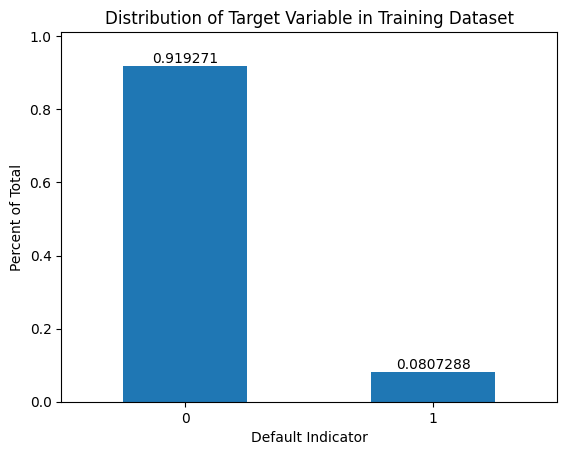

In [ ]:
# Plot the distribution of the Response Variable in the training dataset
# Will need to do some form of undersampling or oversampling to deal with the class imbalance

ax = (d['application_train_df']['target'].value_counts()/len(d['application_train_df'])).plot(kind = 'bar')

plt.title('Distribution of Target Variable in Training Dataset')
plt.xlabel('Default Indicator')
plt.ylabel('Percent of Total')
plt.xticks(rotation = 'horizontal')
ax.bar_label(ax.containers[0], label_type = 'edge')
ax.margins(y = 0.1)
plt.show()

The training dataset has highly unbalanced classes, which could affect our modeling.

#Correlation Analysis
Now, we'll generate a correlation matrix on the training dataset to check for correlation among the features.

In [ ]:
pd.options.display.max_columns = 200
pd.options.display.max_rows = 200

corr = d['application_train_df'].corr(numeric_only = True)
corr.style.background_gradient(cmap = 'coolwarm').format(precision = 2)


ImportError: Pandas requires version '3.0.0' or newer of 'jinja2' (version '2.11.3' currently installed).

Given the size of this correlation matrix, let's set a threshold and view only the features that have correlation greater than a certain threshold.

In [ ]:
# define a threshold
correlation_threshold = 0.7

# get a list of features that exceed this threshold
high_correlation_pairs = []
for i in range(len(corr.columns)):
    for j in range(i + 1, len(corr.columns)):
        if abs(corr.iloc[i, j]) > correlation_threshold:
            high_correlation_pairs.append((corr.columns[i], corr.columns[j]))


high_correlation_pairs


[('cnt_children', 'cnt_fam_members'),
 ('amt_credit', 'amt_annuity'),
 ('amt_credit', 'amt_goods_price'),
 ('amt_annuity', 'amt_goods_price'),
 ('days_employed', 'flag_emp_phone'),
 ('region_rating_client', 'region_rating_client_w_city'),
 ('reg_region_not_work_region', 'live_region_not_work_region'),
 ('reg_city_not_work_city', 'live_city_not_work_city'),
 ('apartments_avg', 'elevators_avg'),
 ('apartments_avg', 'livingapartments_avg'),
 ('apartments_avg', 'livingarea_avg'),
 ('apartments_avg', 'apartments_mode'),
 ('apartments_avg', 'elevators_mode'),
 ('apartments_avg', 'livingapartments_mode'),
 ('apartments_avg', 'livingarea_mode'),
 ('apartments_avg', 'apartments_medi'),
 ('apartments_avg', 'elevators_medi'),
 ('apartments_avg', 'livingapartments_medi'),
 ('apartments_avg', 'livingarea_medi'),
 ('apartments_avg', 'totalarea_mode'),
 ('basementarea_avg', 'basementarea_mode'),
 ('basementarea_avg', 'basementarea_medi'),
 ('years_beginexpluatation_avg', 'years_beginexpluatation_mode

In [ ]:
print(f'There are {len(high_correlation_pairs)} that exhibit correlation greater than {correlation_threshold}.')

There are 127 that exhibit correlation greater than 0.7.


In [ ]:
# create a heatmap of only the high correlation pairs

high_correlation_features = set()

for pair in high_correlation_pairs:
  high_correlation_features.update(pair)

high_correlation_matrix = corr.loc[high_correlation_features, high_correlation_features]
high_correlation_matrix

high_correlation_matrix.style.background_gradient(cmap = 'coolwarm').format(precision = 2)



ImportError: Pandas requires version '3.0.0' or newer of 'jinja2' (version '2.11.3' currently installed).

In [ ]:
pd.options.display.max_rows = 100

## Housing Variables

Many of the highly correlated features are housing variables that have characteristics of their current living situation (characteristics regarding their home or apartment). We will reduce the dimensionality of these features by creating PCA variables on these `housing variables` so that we may use them in our modeling. We will then fit a simple logistic regression to see if there is any predictability of using these outright to see if these variables have any predictability on their own.

Due to the high prevalence of null values in these, we fit the PCA and explore the model with the rows that have no nulls in any of them (~25%), and then fill all missing values with the mean of that respective column before transforming the variables of the main dataframes (train/test).

In [ ]:
housing_variables = ['apartments_avg',
    'basementarea_avg',
    'years_beginexpluatation_avg',
    'years_build_avg',
    'commonarea_avg',
    'elevators_avg',
    'entrances_avg',
    'floorsmax_avg',
    'floorsmin_avg',
    'landarea_avg',
    'livingapartments_avg',
    'livingarea_avg',
    'nonlivingapartments_avg',
    'nonlivingarea_avg',
    'apartments_mode',
    'basementarea_mode',
    'years_beginexpluatation_mode',
    'years_build_mode',
    'commonarea_mode',
    'elevators_mode',
    'entrances_mode',
    'floorsmax_mode',
    'floorsmin_mode',
    'landarea_mode',
    'livingapartments_mode',
    'livingarea_mode',
    'nonlivingapartments_mode',
    'nonlivingarea_mode',
    'apartments_medi',
    'basementarea_medi',
    'years_beginexpluatation_medi',
    'years_build_medi',
    'commonarea_medi',
    'elevators_medi',
    'entrances_medi',
    'floorsmax_medi',
    'floorsmin_medi',
    'landarea_medi',
    'livingapartments_medi',
    'livingarea_medi',
    'nonlivingapartments_medi',
    'nonlivingarea_medi',
    'housetype_mode',
    'totalarea_mode',
    'wallsmaterial_mode',
    'emergencystate_mode']

In [ ]:
print("Percent of rows with valid data for all housing variables: {:.2%}".format((d['application_train_df'][housing_variables].isna().sum(axis = 1) == 0).astype(int).sum() / len(d['application_train_df'])))

Percent of rows with valid data for all housing variables: 26.49%


In [ ]:
d['application_train_df']['emergencystate_mode'].value_counts()

emergencystate_mode
No     159428
Yes      2328
Name: count, dtype: int64

In [ ]:
d['application_train_df']['housetype_mode'].value_counts()

housetype_mode
block of flats      150503
specific housing      1499
terraced house        1212
Name: count, dtype: int64

In [ ]:
#due to the lack of variability for the emergencystate_mode and housetype_mode variables, we will drop them from the dataset
housing_variables.remove('housetype_mode')
housing_variables.remove('emergencystate_mode')

d['application_train_df'].drop(columns = ['housetype_mode','emergencystate_mode'],inplace=True)
d['application_test_df'].drop(columns = ['housetype_mode','emergencystate_mode'],inplace=True)

In [ ]:
d['application_train_df'].groupby('wallsmaterial_mode').agg({'target':'mean','sk_id_curr':'count'}).sort_values(by='target')

,target,sk_id_curr
wallsmaterial_mode,,
Monolithic,0.047218,1779
Panel,0.063477,66040
Block,0.070247,9253
"Stone, brick",0.074057,64815
Mixed,0.075348,2296
Others,0.083077,1625
Wooden,0.096979,5362


There are only 2 prevalent wallsmaterial_mode values, but they have some differentiation in default rates, so we will keep this variable. We will one-hot encode this variable and consider converting all values that are not "Panel" or "Stone, brick" as "Others". All nulls for this column will be filled as "Others"

In [ ]:
#There are only 27 rows that have valid data for all housing variables except wallsmaterial_mode, so fitting the PCA while one-hot encoding the wallsmaterial_mode variable will not be feasible.
d['application_train_df'].dropna(subset = [x for x in housing_variables if x != 'wallsmaterial_mode'])['wallsmaterial_mode'].isna().sum()

27

In [ ]:
d['application_train_df'].loc[~d['application_train_df']['wallsmaterial_mode'].isin(['Panel','Stone, brick']),'wallsmaterial_mode'] = 'Other'
d['application_test_df'].loc[~d['application_test_df']['wallsmaterial_mode'].isin(['Panel','Stone, brick']),'wallsmaterial_mode'] = 'Other'

In [ ]:
d['application_train_df'].groupby('wallsmaterial_mode').agg({'target':'mean','sk_id_curr':'count'}).sort_values(by='target')

,target,sk_id_curr
wallsmaterial_mode,,
Panel,0.063477,66040
"Stone, brick",0.074057,64815
Other,0.089626,176656


In [ ]:
d['application_train_df'] = pd.get_dummies(d['application_train_df'], columns = ['wallsmaterial_mode'])
d['application_test_df'] = pd.get_dummies(d['application_test_df'], columns = ['wallsmaterial_mode'])

wall_material_cols = [x for x in d['application_train_df'].columns if 'wallsmaterial_mode_' in x]

d['application_train_df'][wall_material_cols] = d['application_train_df'][wall_material_cols].astype(int)
d['application_test_df'][wall_material_cols] = d['application_test_df'][wall_material_cols].astype(int)

#remove trhe wallsmaterial_mode column from the housing variables list and append the new one-hot encodedwallsmaterial_mode columns
housing_variables.remove('wallsmaterial_mode')
housing_variables.extend(wall_material_cols)

In [ ]:
#getting a subset with only the rows that have valid data for all housing variables
app_train_housing = d['application_train_df'].dropna(subset=housing_variables).copy()

In [ ]:
app_train_housing[housing_variables] = StandardScaler().fit_transform(app_train_housing[housing_variables])
pca = PCA(n_components = len(housing_variables))
pca.fit(app_train_housing[housing_variables])
explained_variance_ratios = pca.explained_variance_ratio_
cum_evr = explained_variance_ratios.cumsum()

''

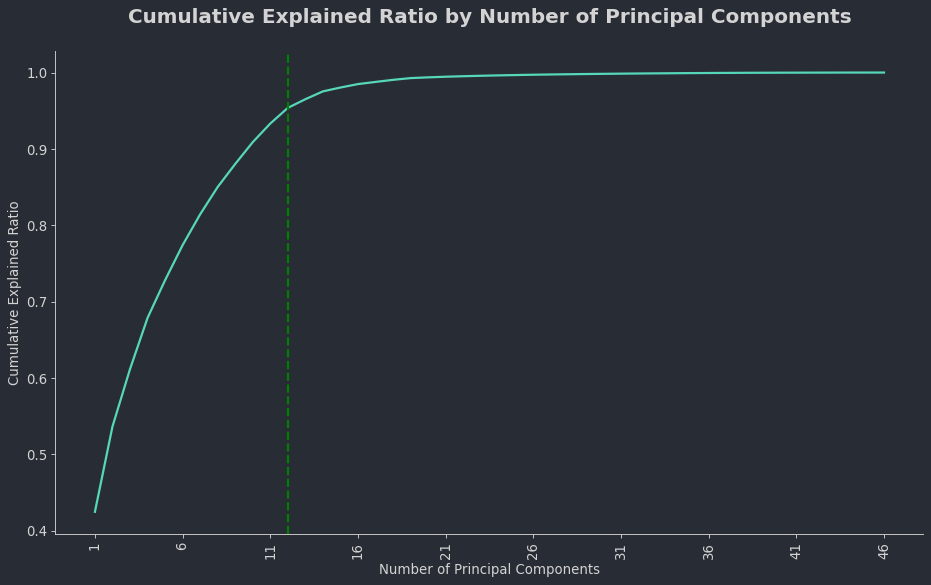

In [ ]:
fig = plt.figure(figsize = (14,8))
ax = fig.add_subplot(111)

ax.plot(cum_evr)
ax.set_xticks(np.arange(0,len(housing_variables),5))
ax.set_xticklabels(np.arange(0,len(housing_variables) ,5) + 1,rotation = 90)

ax.set_xlabel('Number of Principal Components')
ax.set_ylabel('Cumulative Explained Ratio')
ax.set_title('Cumulative Explained Ratio by Number of Principal Components')


#Vertical Line here at 11 really means 12 components
ax.axvline(11,linestyle = '--', color='green')
;

In [ ]:
"{:.2%}".format(cum_evr[11]) #note that 11 is the 12th component

'95.37%'

A PCA with 12 principal componenents allows us to campture 95% of the variability within the housing variables

In [ ]:
pca = PCA(n_components = 12)
pca.fit(app_train_housing[housing_variables])

PCA(n_components=12)

In [ ]:
app_train_housing = pd.concat([app_train_housing,pd.DataFrame(pca.transform(app_train_housing[housing_variables]), columns = ['housing_pca_' + str(x) for x in range(1,13)],index = app_train_housing.index)],axis = 1)

In [ ]:
seed = 42
X_train, X_test, y_train, y_test = train_test_split(app_train_housing[['housing_pca_' + str(x) for x in range(1,13)]],app_train_housing['target'], test_size = 0.3, random_state = seed)

In [ ]:
#Note that we must oversample or undersample to account for the imbalance in the target variable. We will use oversampling here.
d['application_train_df'].target.value_counts()

target
0    282686
1     24825
Name: count, dtype: int64

In [ ]:
X_train_resampled, y_train_resampled = RandomOverSampler(random_state=seed).fit_resample(X_train, y_train)
X_test_resampled, y_test_resampled = RandomOverSampler(random_state=seed).fit_resample(X_test, y_test)

In [ ]:
clf = LogisticRegression(random_state=42,max_iter = 100).fit(X_train_resampled, y_train_resampled)


# Use the model to predict on the test set and save these predictions as `y_pred`
y_pred = clf.predict(X_test_resampled)

#Find the accuracy and store the value in `log_acc`
log_acc = (y_pred == y_test_resampled).sum() / len(y_test_resampled)
print("{:.2%}".format(log_acc))

53.60%


While not a huge boost to predictability, with solely the housing PCA components, we see a 53.6% accuracy score, thus we will keep these features and our model may or may not select them in the future. We will fill in the missing values and perform the modeling again to ensure we get consistent results after filling in nulls values. Many rows have some of the housing variables, with some (or many) being null

In [ ]:
for col in housing_variables:
    d['application_train_df'][col].fillna(d['application_train_df'][col].mean(),inplace=True)
    d['application_test_df'][col].fillna(d['application_test_df'][col].mean(),inplace=True)

In [ ]:
#PCA on train and test after filling nulls. Using the PCA fit on the subset that had no null values
d['application_train_df'] = pd.concat([d['application_train_df'],pd.DataFrame(pca.transform(d['application_train_df'][housing_variables]), columns = ['housing_pca_' + str(x) for x in range(1,13)],index = d['application_train_df'].index)],axis = 1)
d['application_test_df'] = pd.concat([d['application_test_df'],pd.DataFrame(pca.transform(d['application_test_df'][housing_variables]), columns = ['housing_pca_' + str(x) for x in range(1,13)],index = d['application_test_df'].index)],axis = 1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(d['application_train_df'][['housing_pca_' + str(x) for x in range(1,13)]],d['application_train_df']['target'], test_size = 0.3, random_state = seed)
X_train_resampled, y_train_resampled = RandomOverSampler(random_state=seed).fit_resample(X_train, y_train)
X_test_resampled, y_test_resampled = RandomOverSampler(random_state=seed).fit_resample(X_test, y_test)

In [ ]:
clf = LogisticRegression(random_state=42,max_iter = 100).fit(X_train_resampled, y_train_resampled)


# Use the model to predict on the test set and save these predictions as `y_pred`
y_pred = clf.predict(X_test_resampled)

#Find the accuracy and store the value in `log_acc`
log_acc = (y_pred == y_test_resampled).sum() / len(y_test_resampled)
print("{:.2%}".format(log_acc))

53.79%


The predictability remained consistent after filling in Null values with the mean

In [ ]:
#Drop the housing variables that are not the PCA components
d['application_train_df'].drop(columns = housing_variables,inplace=True)
d['application_test_df'].drop(columns = housing_variables,inplace=True)

Let's look at a pairplot.

In [ ]:
#
#df = d['application_train_df']
#df = df[list(high_correlation_features)]
#df.head()

In [ ]:
#sns.pairplot(data = df)

Now, let's plot the distribution of the categorical variables using `sns.countplot()`.

In [ ]:
object_columns = d['application_train_df'].select_dtypes(include=['object']).columns.tolist()
object_columns

['name_contract_type',
 'code_gender',
 'flag_own_car',
 'flag_own_realty',
 'name_type_suite',
 'name_income_type',
 'name_education_type',
 'name_family_status',
 'name_housing_type',
 'occupation_type',
 'weekday_appr_process_start',
 'organization_type',
 'fondkapremont_mode']

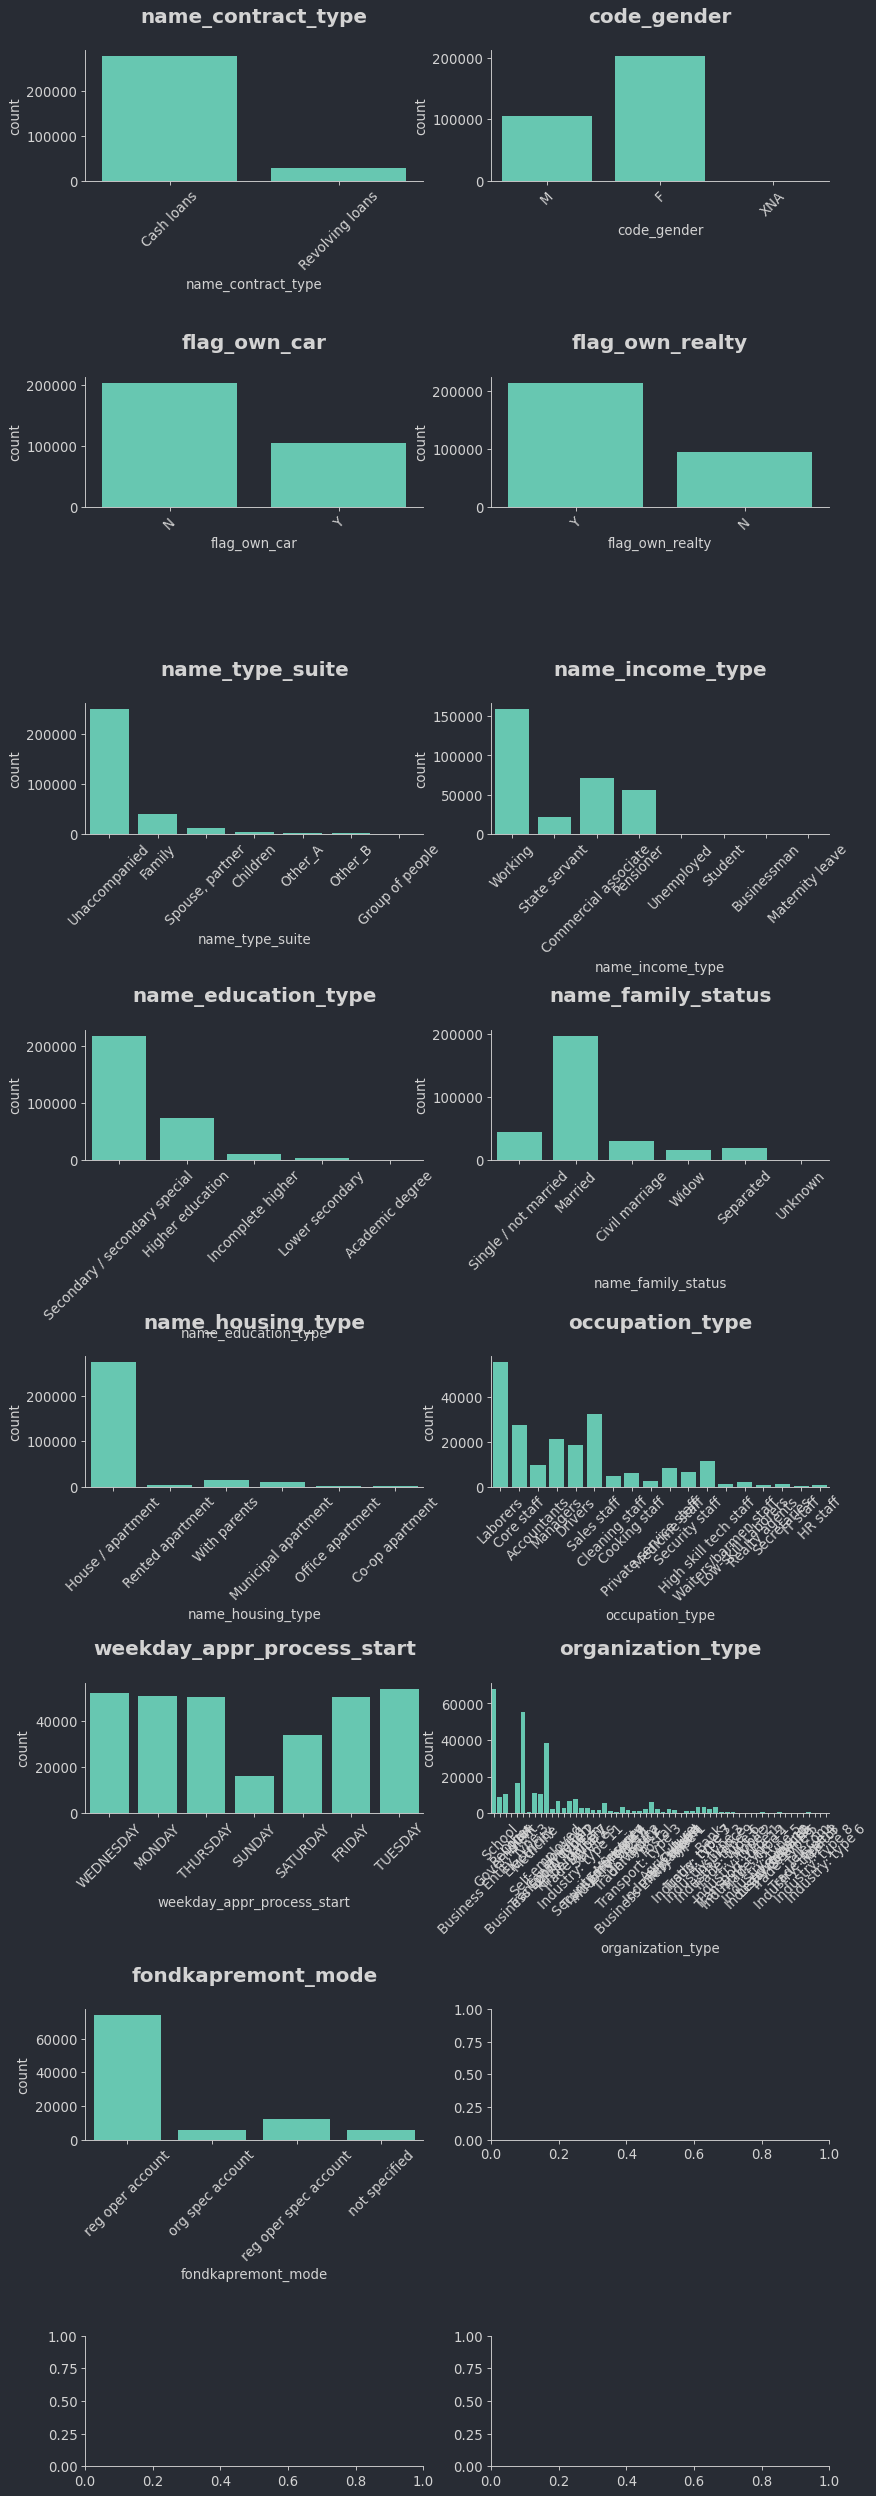

In [ ]:
# plot these

# define height ratios for the subplots
height_ratios = [50] * 7 + [50]

# create a 4x4 subplot grid
fig, axes = plt.subplots(8, 2, figsize=(12, 40), gridspec_kw={'height_ratios': height_ratios})

plt.subplots_adjust(hspace = 1.5)

# flatten the axes array for easy iteration
axes = axes.flatten()

for i, column in enumerate(object_columns):
    sns.countplot(x = column, data = d['application_train_df'], ax = axes[i])
    axes[i].set_title(column)
    axes[i].tick_params(axis='x', rotation=45)

#plt.tight_layout(h_pad = 2.5)
plt.show()

In [ ]:
# initial impressions
# predominent:  married females with a secondary education who own a home (but don't own a car) applying for cash loans

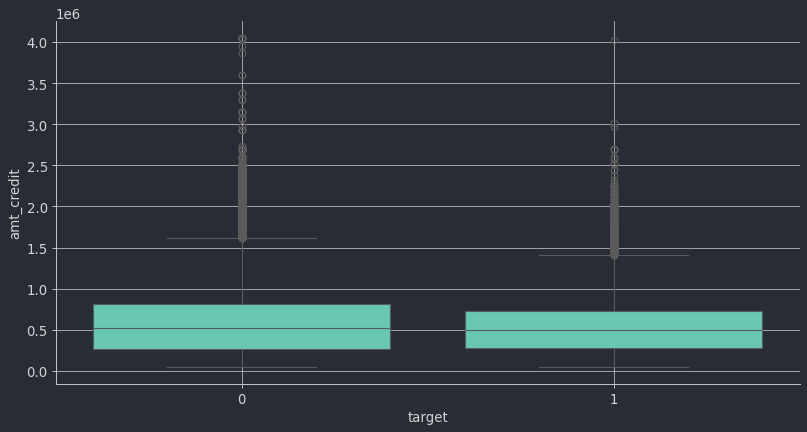

In [ ]:
# Does a large amount of credit result in a default condition?  No!

sns.boxplot(data = d['application_train_df'], x = 'target', y = 'amt_credit')
plt.grid()
plt.show()

In [ ]:
# Do males default more than females?  Yes!

gender_target_counts = d['application_train_df'].groupby(['code_gender', 'target']).size()

gender_target_counts_unstacked = gender_target_counts.unstack('target')

percentage_defaults_by_gender = gender_target_counts_unstacked.div(gender_target_counts_unstacked.sum(axis = 1), axis = 0) * 100

print(percentage_defaults_by_gender)

#Changing gender to a binary variable with 1 = Female, 0 Otherwise
d['application_train_df']['code_gender']  = np.where(d['application_train_df']['code_gender'] == 'F',1,0)
d['application_test_df']['code_gender']  = np.where(d['application_test_df']['code_gender'] == 'F',1,0)

target                0          1
code_gender                       
F             93.000672   6.999328
M             89.858080  10.141920
XNA          100.000000        NaN


In [ ]:
# Do borrowers who own a realty default more than those who do not?  Approximately equal, but home owners are slightly less likely to default

own_realty_target_counts = d['application_train_df'].groupby(['flag_own_realty', 'target']).size()

own_realty_target_counts_unstacked = own_realty_target_counts.unstack('target')

percentage_defaults_by_gender = own_realty_target_counts_unstacked.div(own_realty_target_counts_unstacked.sum(axis = 1), axis = 0) * 100

print(percentage_defaults_by_gender)

d['application_train_df']['flag_own_realty']  = np.where(d['application_train_df']['flag_own_realty'] == 'Y',1,0)
d['application_test_df']['flag_own_realty']  = np.where(d['application_test_df']['flag_own_realty'] == 'Y',1,0)

target                   0         1
flag_own_realty                     
N                91.675071  8.324929
Y                92.038423  7.961577


In [ ]:
# Does the number of children impact default rates?  Approximately equal between 1-2 children, then seemingly impacted between 3-6 children. No children has the lowest default rate.

cnt_children_target_counts = d['application_train_df'].groupby(['cnt_children', 'target']).size()

cnt_children_target_counts_unstacked = cnt_children_target_counts.unstack('target')

percentage_defaults_by_gender = cnt_children_target_counts_unstacked.div(cnt_children_target_counts_unstacked.sum(axis = 1), axis = 0) * 100

print(percentage_defaults_by_gender)

#convert into 2 binary variables, one for having one child, one for having multiple children. People with multiple children will have a 1 in both columns
d['application_train_df']['has_child']  = np.where(d['application_train_df']['cnt_children'] > 0,1,0)
d['application_test_df']['has_child']  = np.where(d['application_test_df']['cnt_children'] > 0,1,0)

d['application_train_df']['has_multiple_children']  = np.where(d['application_train_df']['cnt_children'] > 1,1,0)
d['application_test_df']['has_multiple_children']  = np.where(d['application_test_df']['cnt_children'] > 1,1,0)

d['application_train_df'].drop('cnt_children',axis=1,inplace=True)
d['application_test_df'].drop('cnt_children',axis=1,inplace=True)

target                 0           1
cnt_children                        
0              92.288191    7.711809
1              91.076425    8.923575
2              91.278179    8.721821
3              90.368577    9.631423
4              87.179487   12.820513
5              91.666667    8.333333
6              71.428571   28.571429
7             100.000000         NaN
8             100.000000         NaN
9                    NaN  100.000000
10            100.000000         NaN
11                   NaN  100.000000
12            100.000000         NaN
14            100.000000         NaN
19            100.000000         NaN


In [ ]:
# Do borrowers who own a car default more than those who do not?  Car owners are less likely to default

own_car_target_counts = d['application_train_df'].groupby(['flag_own_car', 'target']).size()

own_car_target_counts_unstacked = own_car_target_counts.unstack('target')

percentage_defaults_by_gender = own_car_target_counts_unstacked.div(own_car_target_counts_unstacked.sum(axis = 1), axis = 0) * 100

print(percentage_defaults_by_gender)

target                0         1
flag_own_car                     
N             91.499773  8.500227
Y             92.756270  7.243730


(0.0, 40.0)

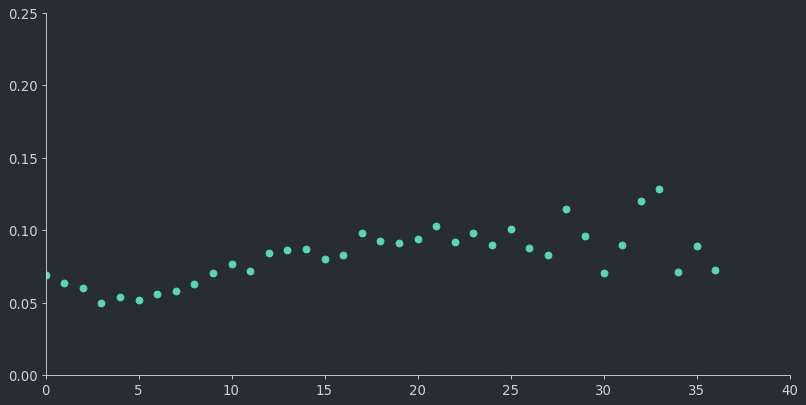

In [ ]:
#Age of Car -- Correlated with default, but with the range of values, it may be better to take the log of this value
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
temp = d['application_train_df'].groupby('own_car_age').agg({'target':['mean','count']})
temp = temp.loc[temp['target']['count'] > 100, 'target']['mean']
ax.scatter(temp.index, temp.values)

ax.set_ylim(0,0.25)
ax.set_xlim(0,40)

(0.0, 5.0)

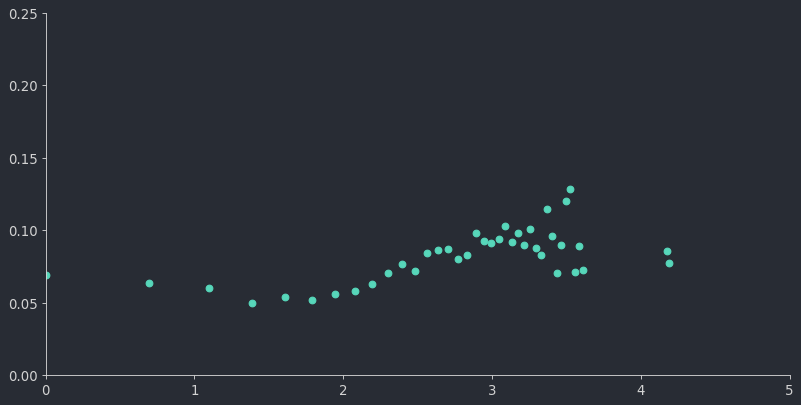

In [ ]:
#car age is correlated, so let's just take the log of it, adding 1 to avoid -inf
d['application_train_df']['own_car_age'] = np.log(d['application_train_df']['own_car_age'] + 1)
d['application_test_df']['own_car_age'] = np.log(d['application_test_df']['own_car_age'] + 1)
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
temp = d['application_train_df'].groupby('own_car_age').agg({'target':['mean','count']})
temp = temp.loc[temp['target']['count'] > 100, 'target']['mean']
ax.scatter(temp.index, temp.values)

ax.set_ylim(0,0.25)
ax.set_xlim(0,5)

In [ ]:
d['application_train_df']['own_car_age'].mean()

2.246389474295695

In [ ]:
d['application_train_df'].loc[d['application_train_df']['own_car_age'].isna(),'target'].mean()

0.08500017247411656

In [ ]:
d['application_train_df']['flag_own_car'].isna().sum()

0

In [ ]:
d['application_train_df'].loc[d['application_train_df']['own_car_age'].isna(),'flag_own_car'].value_counts()

flag_own_car
N    202924
Y         5
Name: count, dtype: int64

In [ ]:
d['application_train_df']['own_car_age'].fillna(d['application_train_df']['own_car_age'].mean(),inplace=True)
d['application_test_df']['own_car_age'].fillna(d['application_test_df']['own_car_age'].mean(),inplace=True)

As shown above, virtually all values with a NULL `own_car_age` has a "N" for `flag_own_car`, thus we do not need another binary variable reprenting that `own_car_age` is NULL. We fill the null `own_car_age` with the mean

hour_appr_process_start
morning          136568
afternoon        118765
early-morning     35828
night             16350
Name: count, dtype: int64

In [ ]:
d['application_train_df'].loc[d['application_train_df']['hour_appr_process_start'] == 9,'target'].mean()

0.08205521472392638

In [ ]:
d['application_train_df'].loc[d['application_train_df']['hour_appr_process_start'].between(2,12),'target'].mean()

0.08472325232419753

In [ ]:
#There does seem to be some correlation with hour of application, although this may be a fluke.
#People who apply in the early-morning have the highest default rate, morning (pre-noon) ,followed by night and then day
def hour_of_application(hour):
    if hour > 17 or hour < 4:
        return 'night'
    elif hour < 9:
        return 'early-morning'
    elif hour <= 12:
        return 'morning'
    else:
        return 'afternoon'

In [ ]:
d['application_train_df']['hour_appr_process_start'].apply(hour_of_application).value_counts()

hour_appr_process_start
morning          136568
afternoon        118765
early-morning     35828
night             16350
Name: count, dtype: int64

In [ ]:
d['application_train_df']['hour_appr_process_start'] = d['application_train_df']['hour_appr_process_start'].apply(hour_of_application)
d['application_test_df']['hour_appr_process_start'] = d['application_test_df']['hour_appr_process_start'].apply(hour_of_application)

(0.0, 0.1)

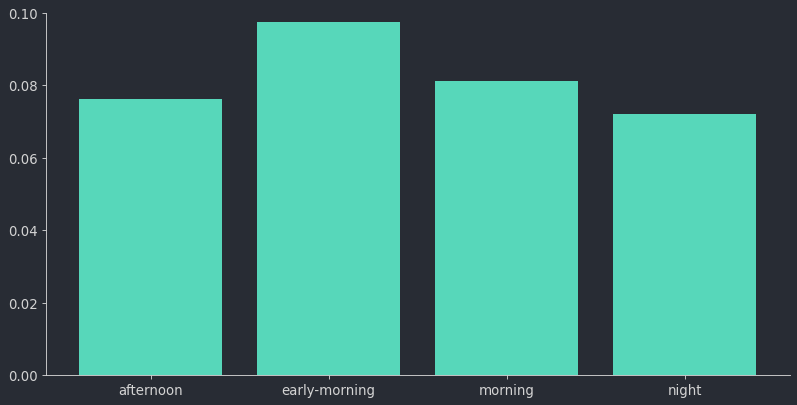

In [ ]:
#There may be a correlation with when people start their application
col = 'hour_appr_process_start'
fig = plt.figure(figsize = (12,6))
ax = fig.add_subplot(111)
ax.bar(x = d['application_train_df'].groupby(col).agg({'target':'mean','sk_id_curr':'count'})['target'].index, height = d['application_train_df'].groupby(col).agg({'target':'mean','sk_id_curr':'count'})['target'].values)

ax.set_ylim(0,0.1)

In [ ]:
#Values other than 'Working','Commercial associate','Pensioner','State servant' are extremely rare for the columns 'name_income_type' and will be grouped into an 'Other' category

print(d['application_train_df']['name_income_type'].value_counts())

d['application_train_df'].loc[~d['application_train_df']['name_income_type'].isin(['Working','Commercial associate','Pensioner','State servant']),'name_income_type'] = 'Other'
d['application_test_df'].loc[~d['application_test_df']['name_income_type'].isin(['Working','Commercial associate','Pensioner','State servant']),'name_income_type'] = 'Other'

name_income_type
Working                 158774
Commercial associate     71617
Pensioner                55362
State servant            21703
Unemployed                  22
Student                     18
Businessman                 10
Maternity leave              5
Name: count, dtype: int64


In [ ]:
#majority of people are solo. Other then Family / spouse or partner, it's pretty sparse, so not worth one-hot encoding. Instead, we have a binary variable for "lives_alone"
print(d['application_train_df']['name_type_suite'].value_counts())

d['application_train_df']['lives_alone']  = np.where(d['application_train_df']['name_type_suite'] == 'Unaccompanied',1,0)
d['application_train_df'].drop('name_type_suite',axis=1,inplace=True)

d['application_test_df']['lives_alone']  = np.where(d['application_test_df']['name_type_suite'] == 'Unaccompanied',1,0)
d['application_test_df'].drop('name_type_suite',axis=1,inplace=True)

name_type_suite
Unaccompanied      248526
Family              40149
Spouse, partner     11370
Children             3267
Other_B              1770
Other_A               866
Group of people       271
Name: count, dtype: int64


In [ ]:
print(d['application_train_df']['name_education_type'].value_counts())

#grouping in Academic Degree with Higher Education as it is a form of Higher Education and there are only 164 rows with Academic Degree
d['application_train_df'].loc[d['application_train_df']['name_education_type'] == 'Academic degree','name_education_type'] = 'Higher education'
d['application_test_df'].loc[d['application_test_df']['name_education_type'] == 'Academic degree','name_education_type'] = 'Higher education'

name_education_type
Secondary / secondary special    218391
Higher education                  74863
Incomplete higher                 10277
Lower secondary                    3816
Academic degree                     164
Name: count, dtype: int64


In [ ]:
#unknown is 2 samples. saving a column by just making it Single / not married
print(d['application_train_df']['name_family_status'].value_counts())
d['application_train_df'].loc[d['application_train_df']['name_family_status'] == 'Unknown','name_family_status'] = 'Single / not married'
d['application_test_df'].loc[d['application_test_df']['name_family_status'] == 'Unknown','name_family_status'] = 'Single / not married'

name_family_status
Married                 196432
Single / not married     45444
Civil marriage           29775
Separated                19770
Widow                    16088
Unknown                      2
Name: count, dtype: int64


In [ ]:
#Why are House / apartment not seperated? -- Makes this feature essentially useless. Will keep this as is and will one-hot encode it
d['application_train_df']['name_housing_type'].value_counts()

name_housing_type
House / apartment      272868
With parents            14840
Municipal apartment     11183
Rented apartment         4881
Office apartment         2617
Co-op apartment          1122
Name: count, dtype: int64

In [ ]:

d['application_train_df'].groupby('name_housing_type').agg({'target':'mean','sk_id_curr':'count'}).sort_values(by='target')

,target,sk_id_curr
name_housing_type,,
Office apartment,0.065724,2617
House / apartment,0.077957,272868
Co-op apartment,0.079323,1122
Municipal apartment,0.085397,11183
With parents,0.116981,14840
Rented apartment,0.123131,4881


In [ ]:
d['application_test_df']['name_housing_type'].value_counts()

name_housing_type
House / apartment      43645
With parents            2234
Municipal apartment     1617
Rented apartment         718
Office apartment         407
Co-op apartment          123
Name: count, dtype: int64

In [ ]:
d['application_train_df'][[x for x in d['application_train_df'].columns if 'amt_req_credit' in x]].isna().sum()

amt_req_credit_bureau_hour    41519
amt_req_credit_bureau_day     41519
amt_req_credit_bureau_week    41519
amt_req_credit_bureau_mon     41519
amt_req_credit_bureau_qrt     41519
amt_req_credit_bureau_year    41519
dtype: int64

For the `amt_req_credit` columns, these represent how many credit pulls they've had during certain time periods. The null values have a higher default rate, so we will fill the nulls with a mean and have a dummy variable for `unknown_credit`

In [ ]:
for col in [x for x in d['application_train_df'].columns if 'amt_req_credit' in x]:
    print(col)
    print(d['application_train_df'][col].value_counts())

amt_req_credit_bureau_hour
amt_req_credit_bureau_hour
0.0    264366
1.0      1560
2.0        56
3.0         9
4.0         1
Name: count, dtype: int64
amt_req_credit_bureau_day
amt_req_credit_bureau_day
0.0    264503
1.0      1292
2.0       106
3.0        45
4.0        26
5.0         9
6.0         8
9.0         2
8.0         1
Name: count, dtype: int64
amt_req_credit_bureau_week
amt_req_credit_bureau_week
0.0    257456
1.0      8208
2.0       199
3.0        58
4.0        34
6.0        20
5.0        10
8.0         5
7.0         2
Name: count, dtype: int64
amt_req_credit_bureau_mon
amt_req_credit_bureau_mon
0.0     222233
1.0      33147
2.0       5386
3.0       1991
4.0       1076
5.0        602
6.0        343
7.0        298
9.0        206
8.0        185
10.0       132
11.0       119
12.0        77
13.0        72
14.0        40
15.0        35
16.0        23
17.0        14
18.0         6
19.0         3
24.0         1
23.0         1
27.0         1
22.0         1
Name: count, dtype: int64
am

In [ ]:
d['application_train_df'].groupby('amt_req_credit_bureau_year')['target'].mean()

amt_req_credit_bureau_year
0.0     0.071350
1.0     0.073338
2.0     0.081049
3.0     0.079577
4.0     0.082553
5.0     0.083223
6.0     0.090713
7.0     0.092013
8.0     0.086037
9.0     0.108577
10.0    0.136364
11.0    0.064516
12.0    0.066667
13.0    0.052632
14.0    0.300000
15.0    0.000000
16.0    0.333333
17.0    0.000000
18.0    0.000000
19.0    0.000000
20.0    0.000000
21.0    0.000000
22.0    1.000000
23.0    0.000000
25.0    0.000000
Name: target, dtype: float64

In [ ]:
d['application_train_df'].loc[d['application_train_df']['amt_req_credit_bureau_year'].isna(),'target'].mean()

0.10337435872732965

In [ ]:
d['application_train_df']['amt_req_credit_bureau_year'].mean()

1.899974435321363

In [ ]:
#dummy variable for the people with missing credit
d['application_train_df']['unknown_credit'] = np.where(d['application_train_df']['amt_req_credit_bureau_year'].isna(),1,0)
d['application_test_df']['unknown_credit'] = np.where(d['application_test_df']['amt_req_credit_bureau_year'].isna(),1,0)

In [ ]:
for col in [x for x in d['application_train_df'].columns if 'amt_req_credit' in x]:
    d['application_train_df'][col].fillna(d['application_train_df'][col].mean(),inplace=True)
    d['application_test_df'][col].fillna(d['application_test_df'][col].mean(),inplace=True)

To fill the nulls in `amt_annuity`, we will use the ratio of `amt_annuity` and `amt_credit` due to the high correlation. Could additionally be modeled, but not worth the time investment due to the small amount of rows

In [ ]:
d['application_train_df']['amt_annuity'].isna().sum()

12

In [ ]:
d['application_test_df']['amt_annuity'].isna().sum()

24

In [ ]:
d['application_train_df'][['amt_annuity','amt_credit']].corr()

,amt_annuity,amt_credit
amt_annuity,1.000000,0.770138
amt_credit,0.770138,1.000000


In [ ]:
annuity_to_credit_ratio = (d['application_train_df']['amt_annuity'] / d['application_train_df']['amt_credit']).mean()

In [ ]:
d['application_train_df'].loc[d['application_train_df']['amt_annuity'].isna(),'amt_annuity'] = d['application_train_df'].loc[d['application_train_df']['amt_annuity'].isna(),'amt_credit'] * annuity_to_credit_ratio

In [ ]:
d['application_test_df'].loc[d['application_test_df']['amt_annuity'].isna(),'amt_annuity'] = d['application_test_df'].loc[d['application_test_df']['amt_annuity'].isna(),'amt_credit'] * annuity_to_credit_ratio

The instances where `amt_goods_price` is null are all revolving loans, making up 1% of the revolving loans. We will set them to the amt_credit in this case due to the correlation

In [ ]:
d['application_train_df'].loc[d['application_train_df']['amt_goods_price'].isna(),'name_contract_type'].value_counts()

name_contract_type
Revolving loans    278
Name: count, dtype: int64

In [ ]:
d['application_train_df'].loc[d['application_train_df']['name_contract_type'] == 'Revolving loans',['amt_credit','amt_goods_price']].corr()

,amt_credit,amt_goods_price
amt_credit,1.000000,0.994901
amt_goods_price,0.994901,1.000000


In [ ]:
d['application_train_df'].loc[d['application_train_df']['name_contract_type'] != 'Revolving loans',['amt_credit','amt_goods_price']].corr()

,amt_credit,amt_goods_price
amt_credit,1.000000,0.986884
amt_goods_price,0.986884,1.000000


In [ ]:
d['application_train_df']['amt_goods_price'].fillna(d['application_train_df']['amt_credit'],inplace=True)
d['application_test_df']['amt_goods_price'].fillna(d['application_test_df']['amt_credit'],inplace=True)

There is only one null value for this `days_last_phone_change`, so we will just fill it with the mean
It is interesting that 12% of the values have `0` as the value for this. This means that 12% of people applying for loans changed their number that day. While it may make sense to make these values null, there is a possibility that recently changing your phone number and applying for credit is correlated. A lot of people applying for emergency funding loans / personal credit loans may be going through something that requires them to also get a new phone number. Due to the possibility of this being rational, we will not void the values of `0`

In [ ]:
d['application_train_df']['days_last_phone_change'].isna().sum()

1

In [ ]:
d['application_train_df']['days_last_phone_change'].value_counts()

days_last_phone_change
 0.0       37672
-1.0        2812
-2.0        2318
-3.0        1763
-4.0        1285
           ...  
-3713.0        1
-3978.0        1
-3983.0        1
-3739.0        1
-3538.0        1
Name: count, Length: 3774, dtype: int64

In [ ]:
d['application_train_df']['days_last_phone_change'].fillna(d['application_train_df']['days_last_phone_change'].mean(),inplace=True)
d['application_test_df']['days_last_phone_change'].fillna(d['application_test_df']['days_last_phone_change'].mean(),inplace=True)

Only two null values in `cnt_fam_members`, but seemingly no correlation to default rate

In [ ]:
d['application_train_df']['cnt_fam_members'].isna().sum()

2

In [ ]:
d['application_train_df']['cnt_fam_members'].value_counts()

cnt_fam_members
2.0     158357
1.0      67847
3.0      52601
4.0      24697
5.0       3478
6.0        408
7.0         81
8.0         20
9.0          6
10.0         3
14.0         2
12.0         2
20.0         2
16.0         2
13.0         1
15.0         1
11.0         1
Name: count, dtype: int64

In [ ]:
d['application_train_df']['cnt_fam_members'].fillna(d['application_train_df']['cnt_fam_members'].mean(),inplace=True)
d['application_test_df']['cnt_fam_members'].fillna(d['application_test_df']['cnt_fam_members'].mean(),inplace=True)

Text(0.5, 1.0, 'Default Rate by Job Tenure Bin -- Filling in Pensioners as 10')

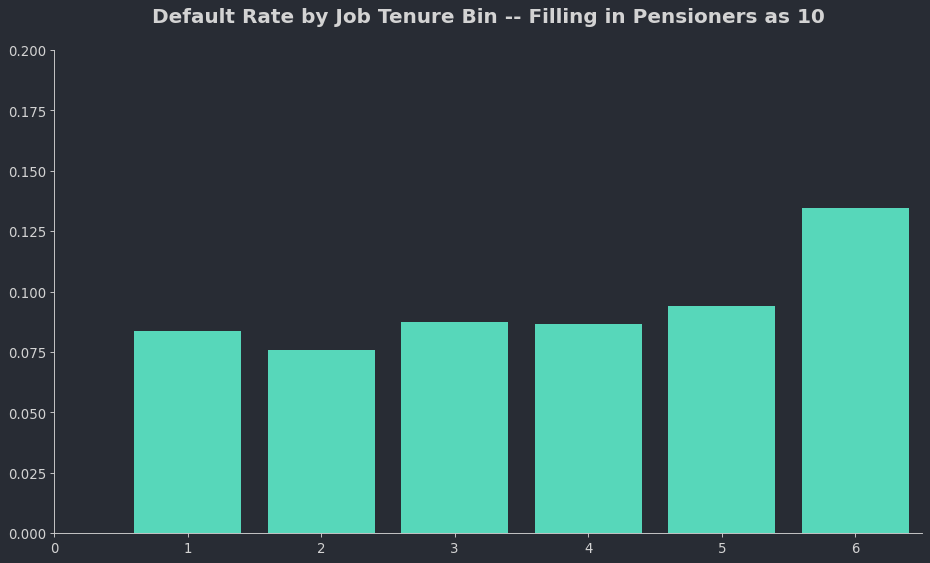

In [ ]:
col = 'cnt_fam_members'
fig = plt.figure(figsize = (14,8))
ax = fig.add_subplot(111)

temp = d['application_train_df'].groupby(col).agg({'target':'mean','sk_id_curr':'count'})
ax.bar(temp.index, temp['target'])


ax.set_xlim(0,6.5)
ax.set_ylim(0,0.2)
ax.set_title('Default Rate by Job Tenure Bin -- Filling in Pensioners as 10')

## External Sources (3 columns labeled with suffix _1, _2, and _3)

In [ ]:
for i in range(1,4,1):
    pct_null = d['application_train_df'][f'ext_source_{i}'].isna().sum() / len(d['application_train_df'])
    print(f'Percent of null values for ext_source_{i}: {pct_null:.2%}')

Percent of null values for ext_source_1: 56.38%
Percent of null values for ext_source_2: 0.21%
Percent of null values for ext_source_3: 19.83%


In [ ]:
temp = d['application_train_df'][['target','ext_source_1','ext_source_2','ext_source_3']].copy()

In [ ]:
temp['ext_source_1_bin'] = pd.qcut(temp['ext_source_1'], q = 10, duplicates = 'drop', labels = np.arange(1,11,1))
temp['ext_source_2_bin'] = pd.qcut(temp['ext_source_2'], q = 10, duplicates = 'drop', labels = np.arange(1,11,1))
temp['ext_source_3_bin'] = pd.qcut(temp['ext_source_3'], q = 10, duplicates = 'drop', labels = np.arange(1,11,1))

In [ ]:
temp1 = temp.groupby('ext_source_1_bin').agg({'target':'mean'})
temp2 = temp.groupby('ext_source_2_bin').agg({'target':'mean'})
temp3 = temp.groupby('ext_source_3_bin').agg({'target':'mean'})

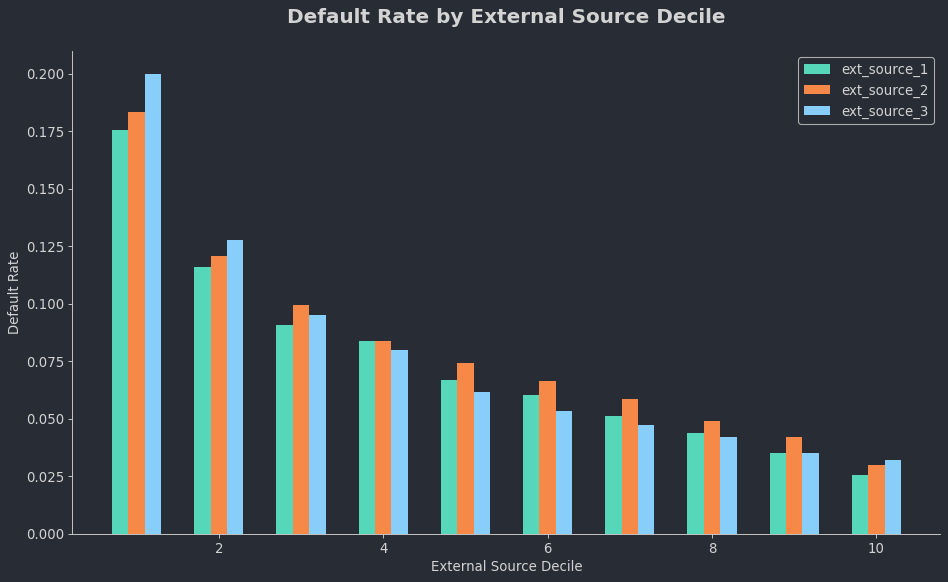

In [ ]:
fig = plt.figure(figsize = (14,8))
ax = fig.add_subplot(111)

#have a bar for each of temp1,temp2,temp3 where each xtick has 3 bars
ax.bar(x = np.arange(1,11,1) - 0.2, height = temp1['target'].values, width = 0.2, label = 'ext_source_1')
ax.bar(x = np.arange(1,11,1), height = temp2['target'].values, width = 0.2, label = 'ext_source_2')
ax.bar(x = np.arange(1,11,1) + 0.2, height = temp3['target'].values, width = 0.2, label = 'ext_source_3')

# ax.set_xticks([0,1])
ax.set_ylabel('Default Rate')
ax.set_xlabel('External Source Decile')
ax.set_title('Default Rate by External Source Decile')

ax.legend()

In [ ]:
temp.corr()

,target,ext_source_1,ext_source_2,ext_source_3,ext_source_1_bin,ext_source_2_bin,ext_source_3_bin
target,1.000000,-0.155317,-0.160472,-0.178919,-0.149048,-0.145196,-0.164200
ext_source_1,-0.155317,1.000000,0.213982,0.186846,0.990999,0.221784,0.182947
ext_source_2,-0.160472,0.213982,1.000000,0.109167,0.209146,0.953964,0.104700
ext_source_3,-0.178919,0.186846,0.109167,1.000000,0.180913,0.107462,0.979436
ext_source_1_bin,-0.149048,0.990999,0.209146,0.180913,1.000000,0.217259,0.177332
ext_source_2_bin,-0.145196,0.221784,0.953964,0.107462,0.217259,1.000000,0.104030
ext_source_3_bin,-0.164200,0.182947,0.104700,0.979436,0.177332,0.104030,1.000000


We can see above that the 3 External sources are very predictive in sloping default rates, and the correlation between the values is reasonable (~20%) with one another. It is worth attempting to model the nulls for ext_source_1 if possible

In [ ]:
ext_source_1_corr = d['application_train_df'].corr(numeric_only=True)['ext_source_1']

In [ ]:
ext_source_1_corr[ext_source_1_corr.abs() > 0.05]

target                        -0.155317
code_gender                    0.306729
flag_own_realty                0.080234
amt_credit                     0.168429
amt_annuity                    0.119402
amt_goods_price                0.175502
region_population_relative     0.099997
days_birth                    -0.600610
days_employed                  0.289848
days_registration             -0.181095
days_id_publish               -0.132375
own_car_age                   -0.064478
flag_emp_phone                -0.294147
flag_work_phone               -0.076540
flag_phone                     0.081241
cnt_fam_members               -0.096569
region_rating_client          -0.115341
region_rating_client_w_city   -0.115374
reg_city_not_live_city        -0.141000
reg_city_not_work_city        -0.185953
live_city_not_work_city       -0.119300
ext_source_1                   1.000000
ext_source_2                   0.213982
ext_source_3                   0.186846
days_last_phone_change        -0.132607


In [ ]:
features_to_model_ext_source_1 = [x for x in d['application_train_df'].isna().sum()[ext_source_1_corr[ext_source_1_corr.abs() > 0.05].index].index if x not in ['target','ext_source_1','ext_source_2','ext_source_3']]

In [ ]:
d['application_train_df'].isna().sum()[features_to_model_ext_source_1]

code_gender                    0
flag_own_realty                0
amt_credit                     0
amt_annuity                    0
amt_goods_price                0
region_population_relative     0
days_birth                     0
days_employed                  0
days_registration              0
days_id_publish                0
own_car_age                    0
flag_emp_phone                 0
flag_work_phone                0
flag_phone                     0
cnt_fam_members                0
region_rating_client           0
region_rating_client_w_city    0
reg_city_not_live_city         0
reg_city_not_work_city         0
live_city_not_work_city        0
days_last_phone_change         0
flag_document_6                0
flag_document_8                0
housing_pca_1                  0
housing_pca_7                  0
housing_pca_10                 0
housing_pca_11                 0
housing_pca_12                 0
has_child                      0
has_multiple_children          0
unknown_cr

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet

### TODO: Improve Modeling technique to predict External Source 1. Maybe some feature selection? This is a placeholder

In [ ]:
#Build a Lasso regression to predict ext_source_1



X_train, X_test, y_train, y_test = train_test_split(d['application_train_df'].loc[d['application_train_df']['ext_source_1'].notna(),features_to_model_ext_source_1],d['application_train_df'].loc[d['application_train_df']['ext_source_1'].notna(),'ext_source_1'], test_size = 0.3, random_state = seed)

#clf = Lasso(random_state=seed,alpha = 1).fit(X_train, y_train)
ridge_reg = Ridge(random_state=seed,alpha = 1).fit(X_train, y_train)
# lin_reg = LinearRegression().fit(X_train, y_train)
#elastic_net_reg = ElasticNet(random_state=seed,alpha = 1).fit(X_train, y_train)

In [ ]:
ridge_reg.score(X_test,y_test)

0.45542756757651104

In [ ]:
d['application_train_df']['modeled_ext_source_1'] = ridge_reg.predict(d['application_train_df'][features_to_model_ext_source_1])
d['application_test_df']['modeled_ext_source_1'] = ridge_reg.predict(d['application_test_df'][features_to_model_ext_source_1])

In [ ]:
d['application_train_df']['null_ext_source_1'] = np.where(d['application_train_df']['ext_source_1'].isna(),1,0)
d['application_test_df']['null_ext_source_1'] = np.where(d['application_test_df']['ext_source_1'].isna(),1,0)

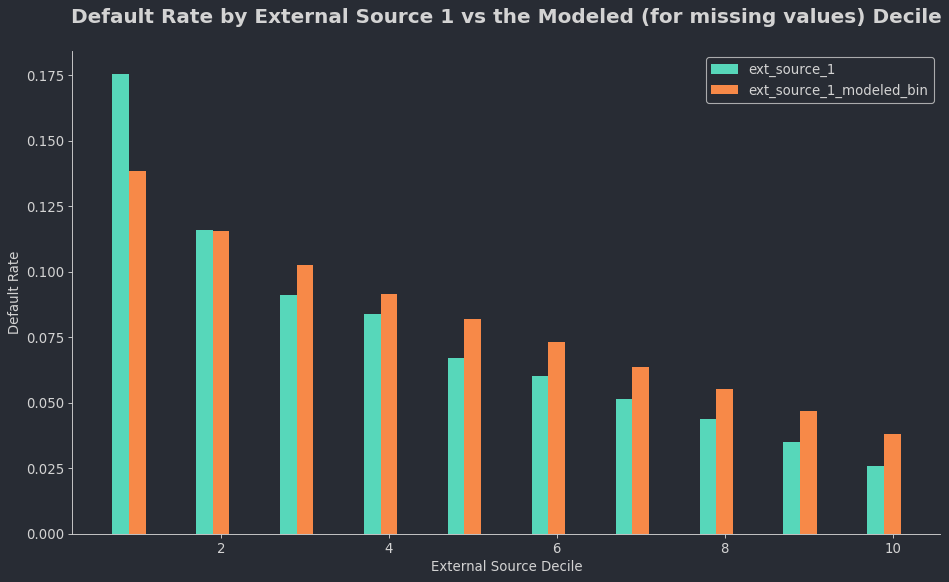

In [ ]:
temp = d['application_train_df'][['target','ext_source_1','modeled_ext_source_1']].copy()
temp['ext_source_1_bin'] = pd.qcut(temp['ext_source_1'], q = 10, duplicates = 'drop', labels = np.arange(1,11,1))
temp['ext_source_1_modeled_bin'] = pd.qcut(temp['modeled_ext_source_1'], q = 10, duplicates = 'drop', labels = np.arange(1,11,1))


temp1 = temp.groupby('ext_source_1_bin').agg({'target':'mean'})
temp2 = temp.groupby('ext_source_1_modeled_bin').agg({'target':'mean'})

fig = plt.figure(figsize = (14,8))
ax = fig.add_subplot(111)

#have a bar for each of temp1,temp2,temp3 where each xtick has 3 bars
ax.bar(x = np.arange(1,11,1) - 0.2, height = temp1['target'].values, width = 0.2, label = 'ext_source_1')
ax.bar(x = np.arange(1,11,1), height = temp2['target'].values, width = 0.2, label = 'ext_source_1_modeled_bin')

# ax.set_xticks([0,1])
ax.set_ylabel('Default Rate')
ax.set_xlabel('External Source Decile')
ax.set_title('Default Rate by External Source 1 vs the Modeled (for missing values) Decile')

ax.legend()

C:\Users\paulh\AppData\Local\Temp\ipykernel_27676\4068117924.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Not Null','Null'])


''

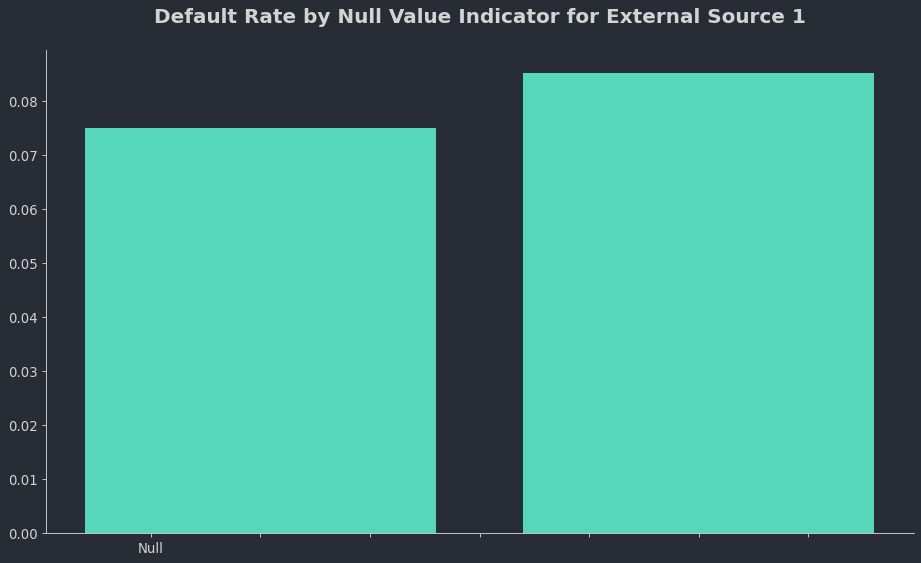

In [ ]:
col = 'null_ext_source_1'
fig = plt.figure(figsize = (14,8))
ax = fig.add_subplot(111)

temp = d['application_train_df'].groupby(col).agg({'target':'mean','sk_id_curr':'count'})
ax.bar(temp.index, temp['target'])

ax.set_title('Default Rate by Null Value Indicator for External Source 1')

ax.set_xticklabels(['Not Null','Null'])

;

In [ ]:
d['application_train_df']['modeled_ext_source_1'] = ridge_reg.predict(d['application_train_df'][features_to_model_ext_source_1])
d['application_test_df']['modeled_ext_source_1'] = ridge_reg.predict(d['application_test_df'][features_to_model_ext_source_1])

In [ ]:
d['application_train_df']['ext_source_1'].fillna(d['application_train_df']['modeled_ext_source_1'],inplace=True)
d['application_test_df']['ext_source_1'].fillna(d['application_test_df']['modeled_ext_source_1'],inplace=True)

d['application_train_df'].drop(columns = ['null_ext_source_1'],inplace=True)
d['application_test_df'].drop(columns = ['null_ext_source_1'],inplace=True)

Not sure what the column `fondkapremont_mode` means, but the categorical variable seems to slope to default somewhat, especially with Missing values having the highest default rate

In [ ]:
d['application_train_df']['fondkapremont_mode'].value_counts()

fondkapremont_mode
reg oper account         73830
reg oper spec account    12080
not specified             5687
org spec account          5619
Name: count, dtype: int64

In [ ]:
d['application_train_df']['fondkapremont_mode'].fillna('missing',inplace=True)

Text(0.5, 1.0, 'Default Rate by fondkapremont_mode')

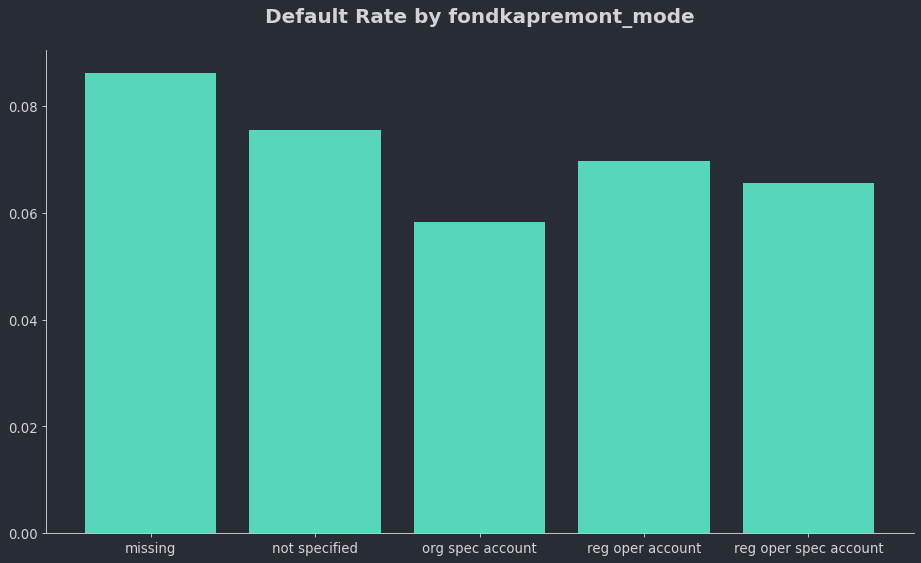

In [ ]:
col = 'fondkapremont_mode'
fig = plt.figure(figsize = (14,8))
ax = fig.add_subplot(111)

temp = d['application_train_df'].groupby(col).agg({'target':'mean','sk_id_curr':'count'})
ax.bar(temp.index, temp['target'])

ax.set_title('Default Rate by fondkapremont_mode')

For `occupation_type`, nulls are theoretically have value because no known occupation hypothetically may be indicative of default risk. Off of a simple aggregation, it is not, but there may be hidden relationships with other variables

In [ ]:
d['application_train_df']['occupation_type'].fillna('Unknown',inplace=True)
d['application_test_df']['occupation_type'].fillna('Unknown',inplace=True)

In [ ]:
d['application_train_df']['occupation_type'].value_counts()

occupation_type
Unknown                  96391
Laborers                 55186
Sales staff              32102
Core staff               27570
Managers                 21371
Drivers                  18603
High skill tech staff    11380
Accountants               9813
Medicine staff            8537
Security staff            6721
Cooking staff             5946
Cleaning staff            4653
Private service staff     2652
Low-skill Laborers        2093
Waiters/barmen staff      1348
Secretaries               1305
Realty agents              751
HR staff                   563
IT staff                   526
Name: count, dtype: int64

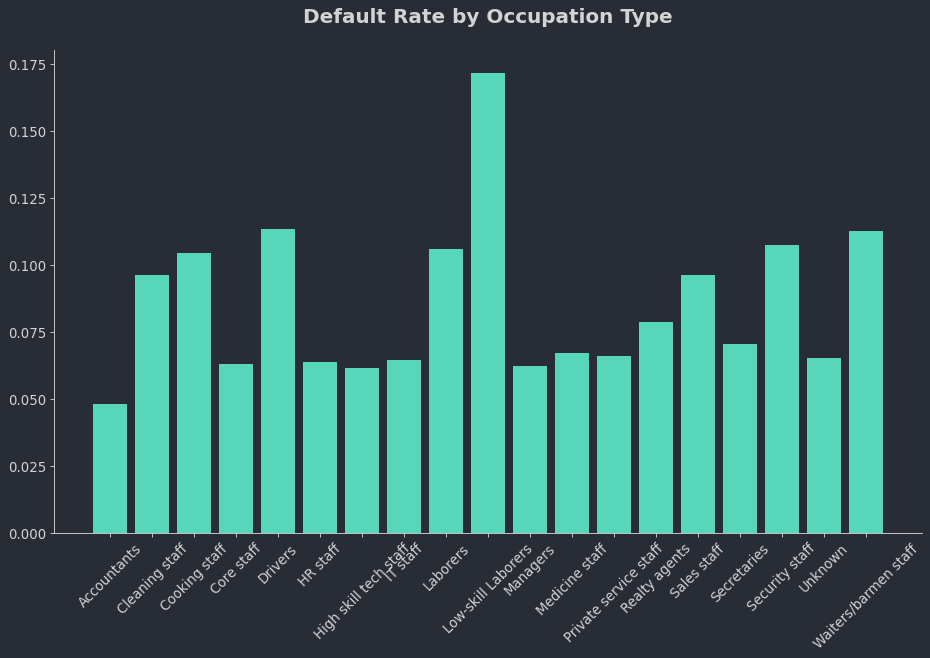

In [ ]:
col = 'occupation_type'
fig = plt.figure(figsize = (14,8))
ax = fig.add_subplot(111)

temp = d['application_train_df'].groupby(col).agg({'target':'mean','sk_id_curr':'count'})
ax.bar(temp.index, temp['target'])

ax.set_title('Default Rate by Occupation Type')

plt.xticks(rotation = '45');

There are only a small amount of null values for social circle variables (~0.27%), so we will just use the mean

In [ ]:
d['application_train_df'].isna().sum()[[x for x in d['application_train_df'].columns if 'social_circle' in x]]

obs_30_cnt_social_circle    1021
def_30_cnt_social_circle    1021
obs_60_cnt_social_circle    1021
def_60_cnt_social_circle    1021
dtype: int64

In [ ]:
for col in [x for x in d['application_train_df'].columns if 'social_circle' in x]:
    d['application_train_df'][col].fillna(d['application_train_df'][col].mean(),inplace=True)
    d['application_test_df'][col].fillna(d['application_test_df'][col].mean(),inplace=True)

In [ ]:
d['application_train_df']['obs_60_cnt_social_circle'].value_counts()

obs_60_cnt_social_circle
0.000000      164666
1.000000       48870
2.000000       29766
3.000000       20215
4.000000       13946
5.000000        9463
6.000000        6349
7.000000        4344
8.000000        2886
9.000000        1959
10.000000       1335
1.405292        1021
11.000000        837
12.000000        620
13.000000        401
14.000000        238
15.000000        166
16.000000        137
17.000000         73
18.000000         49
19.000000         44
20.000000         30
21.000000         28
22.000000         20
23.000000         13
24.000000         12
25.000000         11
27.000000          5
29.000000          2
28.000000          1
47.000000          1
344.000000         1
30.000000          1
26.000000          1
Name: count, dtype: int64

In [ ]:
d['application_train_df']['def_60_cnt_social_circle'].value_counts()

def_60_cnt_social_circle
0.000000     280721
1.000000      21841
2.000000       3170
0.100049       1021
3.000000        598
4.000000        135
5.000000         20
6.000000          3
7.000000          1
24.000000         1
Name: count, dtype: int64

In [ ]:
#We should also try taking the log of each due to the distribution
for col in [x for x in d['application_train_df'].columns if 'social_circle' in x]:
    d['application_train_df'][col + '_log'] = np.log(d['application_train_df'][col] + 1)
    d['application_test_df'][col + '_log'] = np.log(d['application_test_df'][col] + 1)

In [ ]:
object_cols = []
for col in d['application_train_df'].columns:
    if d['application_train_df'][col].dtype == 'object':
        object_cols.append(col)

In [ ]:
#one hot encode all the object columns
for col in object_cols:
    d['application_train_df'] = pd.get_dummies(d['application_train_df'],columns = [col],prefix=col)
    d['application_test_df'] = pd.get_dummies(d['application_test_df'],columns = [col],prefix=col)

In [ ]:
#convert all the boolean columns to int
for col in d['application_train_df'].columns:
    if d['application_train_df'][col].dtype == bool:
        d['application_train_df'][col] = d['application_train_df'][col].astype(int)
        d['application_test_df'][col] = d['application_test_df'][col].astype(int)

## Results of Exploratory Data Analysis

Placeholder for results of our EDA...

*   List item
*   List item



#Feature Engineering

## Some New Features

In [ ]:
#I accidentally overwrote my dataframe but wanted to include these before I hopped of. i.e. no graphs or analysis, just code. Will delete this comment later
d['application_train_df']['payment_to_income_ratio'] = d['application_train_df']['amt_annuity'] / d['application_train_df']['amt_income_total']
d['application_train_df']['additional_credit_pct_over_price'] = (d['application_train_df']['amt_credit'] - d['application_train_df']['amt_goods_price']) / d['application_train_df']['amt_goods_price']

KeyError: 'amt_annuity'

In [ ]:
col = 'payment_to_income_ratio'
fig = plt.figure(figsize = (14,8))
ax = fig.add_subplot(111)

temp = d['application_train_df'].groupby(col).agg({'target':'mean','sk_id_curr':'count'})
ax.bar(temp.index, temp['target'])


ax.set_xlim(0,6.5)
ax.set_ylim(0,0.2)
ax.set_title('Default Rate by Payment to Income (PTI) Ratio')

In [ ]:
col = 'additional_credit_pct_over_price'
fig = plt.figure(figsize = (14,8))
ax = fig.add_subplot(111)

temp = d['application_train_df'].groupby(col).agg({'target':'mean','sk_id_curr':'count'})
ax.bar(temp.index, temp['target'])


ax.set_xlim(0,6.5)
ax.set_ylim(0,0.2)
ax.set_title('Default Rate by Additional Credit Pct Over Price')

# TODO: Model out External Source 2. Fill External Source 3. Bring in CC Data/other datasets. Find a good NDI metric with the data